In [2]:
import torch
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchmetrics

import pandas as pd
from tqdm.notebook import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
import gensim.downloader
from sklearn.linear_model import LinearRegression
import swifter
import seaborn as sns


device = 'cpu'

In [3]:
#df = pd.read_json('gutenberg-dataset-v2.json')
df = pd.read_json('dataset.json')
#embedding_vectors = gensim.downloader.load('glove-twitter-25')

#embedding_dim = len(embedding_vectors['test'])
chunk_size = 2000


In [4]:
total_vocabulary = set()
for row in tqdm(df.iterrows(), total=len(df)):
    text = row[1]['text']
    words = text.split()
    for word in words:
        total_vocabulary.add(word)

len(total_vocabulary)

  0%|          | 0/13128 [00:00<?, ?it/s]

3112272

In [5]:
total_frequencies = {word: 0 for word in total_vocabulary}
for row in tqdm(df.iterrows(), total=len(df)):
    text = row[1]['text']
    words = text.split()
    for word in words:
        total_frequencies[word] = total_frequencies[word] + 1


  0%|          | 0/13128 [00:00<?, ?it/s]

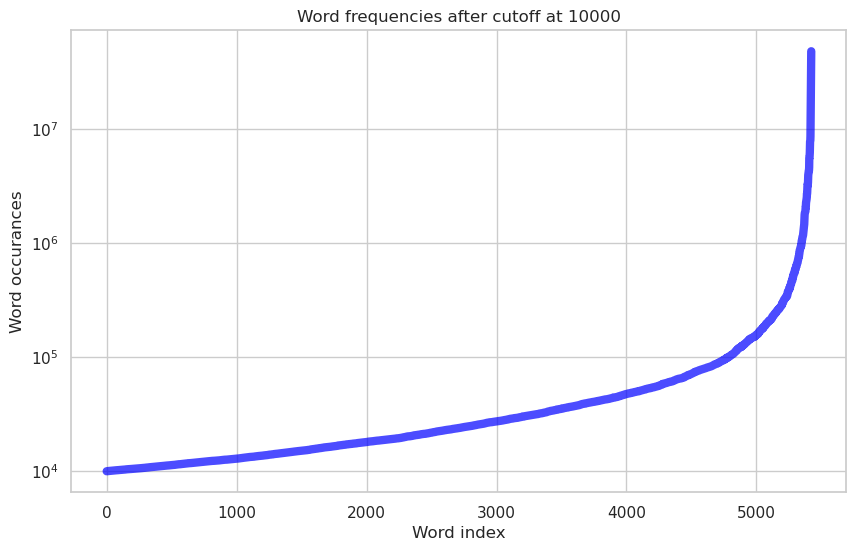

5423


In [57]:
frequency_cutoff = 10000 #300 # 500 #10000

f = [total_frequencies[x] for x in total_frequencies if total_frequencies[x] > frequency_cutoff]
f.sort()

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
#sns.scatterplot(x=results_df['Real Published Date'], y=results_df['Estimated Date'], color='blue', alpha=0.5, edgecolor='none')

plt.plot(f, color='blue', alpha=0.7, linewidth=6)
plt.yscale('log')
plt.xlabel('Word index')
plt.ylabel('Word occurances')
plt.title('Word frequencies after cutoff at 10000')

plt.savefig('word-freq-log-scale2.png', bbox_inches='tight', pad_inches=0, transparent=True)

plt.show()

print(len(f))


In [59]:
f2 = [(total_frequencies[x], x) for x in total_frequencies if total_frequencies[x] > frequency_cutoff]

f2


In [61]:
f2.sort()

In [64]:
df2 = pd.DataFrame(f2)

In [67]:
df2.head(20)

,0,1
0,10003,aye
1,10005,undertaken
2,10014,carpet
3,10014,slopes
4,10015,cab
5,10017,bounds
6,10018,dost
7,10025,sworn
8,10027,truths
9,10027,warn


In [12]:
select_frequencies = {}
select_vocabulary = []

select_vocabulary_set = set()

for word in tqdm(total_vocabulary):
    f = total_frequencies[word]
    if f > frequency_cutoff: #old: 500
        select_frequencies[word] = f
        select_vocabulary.append(word)
        select_vocabulary_set.add(word)


  0%|          | 0/3112272 [00:00<?, ?it/s]

In [13]:
tqdm.pandas()

def count_word_frequencies(text):
    frequencies = {word: 0 for word in select_vocabulary}
    words = text.split()
    word_count = len(words)
    for word in words:
        if word in select_vocabulary_set:
            frequencies[word] = frequencies[word] + 1

    list = np.zeros(len(select_vocabulary))
    for index, word in enumerate(select_vocabulary):
        freq = frequencies[word] / word_count
        if freq != 0:
            list[index] = -np.log(freq)
        else:
            list[index] = 0

    return list


df['word_frequencies'] = df['text'].progress_apply(count_word_frequencies)

  0%|          | 0/13128 [00:00<?, ?it/s]

In [14]:
for index, word in tqdm(enumerate(select_vocabulary), total=len(select_vocabulary)):
    df['W: ' + word] = df['word_frequencies'].apply(lambda l: l[index])


  0%|          | 0/5423 [00:00<?, ?it/s]

/tmp/ipykernel_14043/27503632.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['W: ' + word] = df['word_frequencies'].apply(lambda l: l[index])
/tmp/ipykernel_14043/27503632.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['W: ' + word] = df['word_frequencies'].apply(lambda l: l[index])
/tmp/ipykernel_14043/27503632.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conca

In [15]:
#df = (df.drop('title', axis=1).drop('author', axis=1).drop('text_ratio', axis=1).drop('text', axis=1).drop('weights', axis=1).drop('word_frequencies', axis=1).drop('text_len_characters', axis=1))
#df = (df.drop('title', axis=1).drop('author', axis=1).drop('text_ratio', axis=1).drop('text', axis=1).drop('word_frequencies', axis=1))

df = df.copy()

In [16]:
df = (df.drop('title', axis=1).drop('author', axis=1).drop('text_ratio', axis=1).drop('text', axis=1).drop('word_frequencies', axis=1))

In [17]:
df

,date,W: reply,W: poets,W: welcome,W: try,W: wife,W: committee,W: motionless,W: sets,W: el,...,W: it,W: better,W: somebody,W: amazement,W: squadron,W: extension,W: monarch,W: water,W: team,W: closing
0,1904,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,4.203498,8.115521,7.422374,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1780,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,3.994792,8.815073,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,1884,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,8.57414,0.000000,0.000000,...,4.415257,7.880993,8.574140,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,1902,0.000000,0.000000,8.967326,8.967326,7.937706,0.00000,0.00000,10.576764,0.000000,...,4.741953,8.274179,9.478151,9.190469,0.0,0.0,0.000000,9.478151,0.000000,10.576764
4,1915,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,3.976338,0.000000,0.000000,0.000000,0.0,0.0,0.000000,7.308543,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,2023,0.000000,8.764333,9.917012,8.875558,8.764333,0.00000,0.00000,10.322477,11.708772,...,4.990967,8.182411,0.000000,0.000000,0.0,0.0,10.322477,8.875558,0.000000,10.610160
13124,2023,10.204092,10.897239,9.105480,9.798627,7.463252,0.00000,0.00000,0.000000,5.913633,...,5.008361,8.700015,0.000000,10.204092,0.0,0.0,10.897239,7.113050,0.000000,10.897239
13125,2023,0.000000,0.000000,0.000000,6.224558,0.000000,0.00000,0.00000,0.000000,0.000000,...,4.084492,6.917706,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
13126,1916,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,5.082568,7.855157,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [18]:
# df['date'] = (df['date']-df['date'].min())/(df['date'].max()-df['date'].min())

date_min = df['date'].min()
date_max = df['date'].max()


df = (df-df.min())/(df.max()-df.min())

df

,date,W: reply,W: poets,W: welcome,W: try,W: wife,W: committee,W: motionless,W: sets,W: el,...,W: it,W: better,W: somebody,W: amazement,W: squadron,W: extension,W: monarch,W: water,W: team,W: closing
0,0.631579,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.347695,0.667334,0.521289,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,0.247678,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.330432,0.724858,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,0.569659,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.60218,0.000000,0.000000,...,0.365211,0.648049,0.602180,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,0.625387,0.000000,0.00000,0.661004,0.690715,0.631018,0.000000,0.00000,0.805619,0.000000,...,0.392234,0.680380,0.665670,0.681043,0.0,0.0,0.000000,0.754598,0.000000,0.780840
4,0.665635,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.328906,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.581866,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,1.000000,0.000000,0.61123,0.731007,0.683646,0.696732,0.000000,0.00000,0.786250,0.872875,...,0.412831,0.672834,0.000000,0.000000,0.0,0.0,0.797930,0.706623,0.000000,0.783306
13124,1.000000,0.769805,0.75998,0.671187,0.754746,0.593301,0.000000,0.00000,0.000000,0.440854,...,0.414270,0.715397,0.000000,0.756156,0.0,0.0,0.842359,0.566301,0.000000,0.804500
13125,1.000000,0.000000,0.00000,0.000000,0.479451,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.337852,0.568838,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
13126,0.668731,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.420408,0.645925,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000


1700

In [36]:
X = df.iloc[:, 1:]
y = df['date']

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42, shuffle=True)

In [14]:
#train_dataloader = DataLoader((torch.from_numpy(X_train), torch.from_numpy(y_train)), batch_size=16)
#test_dataloader = DataLoader((torch.from_numpy(X_test), torch.from_numpy(y_test)), batch_size=16)

In [22]:
# Define the linear regression model



class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        # self.activation = nn.Sigmoid()
        # self.linear2 = nn.Linear(1000, 1000)
        # self.activation2 = nn.ReLU()
        # self.linear3 = nn.Linear(1000, 100)
        # self.activation3 = nn.ReLU()
        # self.linear4 = nn.Linear(1000, 1)
        #self.activation4 = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        # x = self.activation(x)
        # x = self.linear2(x)
        # x = self.activation2(x)
        # x = self.linear3(x)
        # x = self.activation3(x)
        # x = self.linear4(x)
        # x = self.activation4(x)

        return x

In [23]:
df.isnull().values.any()


False

In [43]:
# Initialize the model, loss function, and optimizer

num_epochs = 200
loading_steps = 10
loading_count = 0

learning_rate = 0.001

input_size = X_train.shape[1]
model = LinearRegressionModel(input_size)
model.to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

train_loader = DataLoader(train_dataset, batch_size=len(X_train_tensor) // 1, shuffle=True)

losses = []


model.train()

for epoch in tqdm(range(num_epochs)):

    for inputs, labels in (train_loader):
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()

        # https://stackoverflow.com/questions/66648432/pytorch-test-loss-becoming-nan-after-some-iteration
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        optimizer.step()

    if epoch % (num_epochs / loading_steps) == 0:
        print(f'{loading_count}0% done')
        print(f'Loss: {loss}')
        loading_count = loading_count + 1

print('finished')


  0%|          | 0/200 [00:00<?, ?it/s]

00% done
Loss: 0.42024779319763184
10% done
Loss: 0.23343518376350403
20% done
Loss: 0.17048849165439606
30% done
Loss: 0.14548726379871368
40% done
Loss: 0.1305471956729889
50% done
Loss: 0.11954846978187561
60% done
Loss: 0.11085573583841324
70% done
Loss: 0.10870583355426788
80% done
Loss: 0.10818932205438614
90% done
Loss: 0.10515626519918442
finished


In [41]:
model.train()
loading_count = 0

for epoch in tqdm(range(1000)):

    for inputs, labels in (train_loader):
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()

        # https://stackoverflow.com/questions/66648432/pytorch-test-loss-becoming-nan-after-some-iteration
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        optimizer.step()

    if epoch % (num_epochs / loading_steps) == 0:
        print(f'{loading_count}0% done')
        print(f'Loss: {loss}')
        loading_count = loading_count + 1


  0%|          | 0/1000 [00:00<?, ?it/s]

00% done
Loss: 0.11072729527950287
10% done
Loss: 0.1265411525964737
20% done
Loss: 0.08317732810974121
30% done
Loss: 0.07265845686197281
40% done
Loss: 0.07837167382240295
50% done
Loss: 0.06712361425161362
60% done
Loss: 0.24785518646240234
70% done
Loss: 0.43541738390922546
80% done
Loss: 0.23917005956172943
90% done
Loss: 0.15882925689220428
100% done
Loss: 0.38842105865478516
110% done
Loss: 0.22340445220470428
120% done
Loss: 0.15547125041484833
130% done
Loss: 0.35118308663368225
140% done
Loss: 0.21439702808856964
150% done
Loss: 0.14804068207740784
160% done
Loss: 0.33027756214141846
170% done
Loss: 0.20700865983963013
180% done
Loss: 0.1426258087158203
190% done
Loss: 0.3199627101421356
200% done
Loss: 0.2076190710067749
210% done
Loss: 0.13147501647472382
220% done
Loss: 0.3094025254249573
230% done
Loss: 0.20632405579090118
240% done
Loss: 0.1251377910375595
250% done
Loss: 0.2994772493839264
260% done
Loss: 0.19886358082294464
270% done
Loss: 0.1286180317401886
280% done


Mean absolute Error: 1898.427275042602
[1920. 1890. 1909. ... 1921. 1922. 1916.]
Mean absolute Error: -17.380869043935643
[43.26642]
[17.21249048]


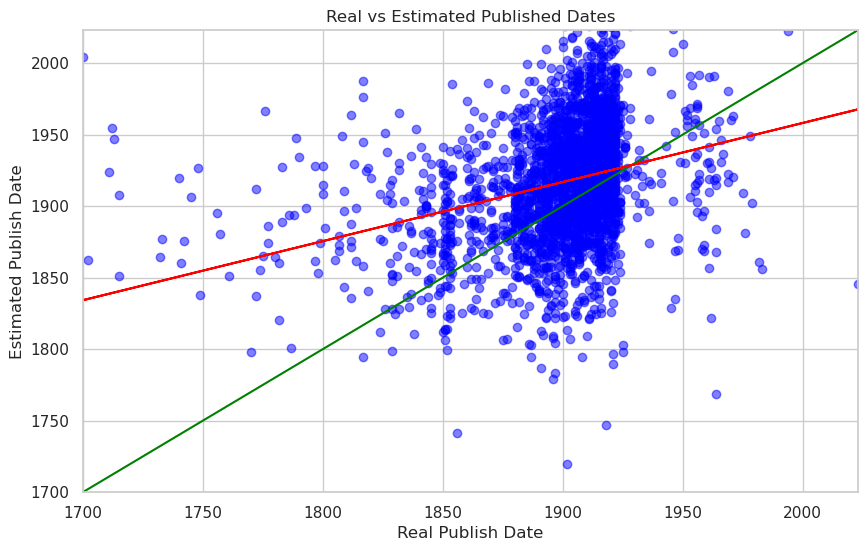

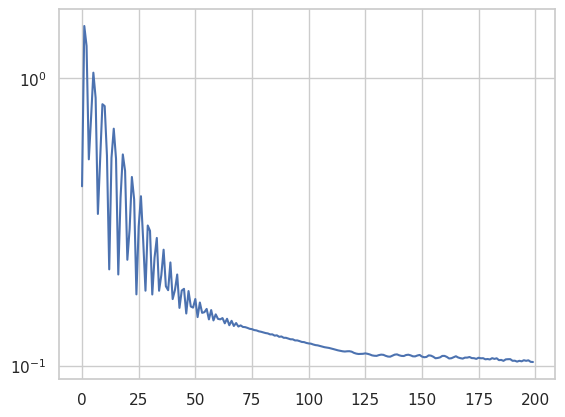

In [50]:
model.eval()


def calculate_mean_absolute_error(predictions, labels):
    return sum([abs(pred - label) for pred, label in zip(predictions, labels)]) / len(predictions)

def calculate_stadard_deviation(predictions):
    mean = sum(predictions) / len(predictions)
    return (sum([(pred - mean) ** 2 for pred in predictions]) / len(predictions)) ** 0.5

def calculate_percentage_of_predictions_within_10_years(predictions, labels):
    return sum([abs(pred - label) <= 10 for pred, label in zip(predictions, labels)]) / len(predictions) * 100



with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_pred = model(X_test_tensor).detach().numpy()

    # Calculate the mean squared error to evaluate the model
    mse = ((y_test - y_pred)).mean()
    print(f"Mean absolute Error: {mse}")

    # plt.hist(y_pred, bins=100)
    # plt.show()

    # plt.hist(y_test, bins=100)
    # plt.show()

    print(y_test)

    date_diff = date_max - date_min
    # y_test = y_test * date_diff
    y_pred = y_pred * date_diff

    # y_test = y_test + date_min
    y_pred = y_pred + date_min


    mse = ((y_test - y_pred)).mean()
    print(f"Mean absolute Error: {mse}")

    print(calculate_stadard_deviation(y_pred))
    print(calculate_percentage_of_predictions_within_10_years(y_pred, y_test))


    plt.figure(figsize=(10, 6))

    plt.scatter(y_test, y_pred, color='blue', alpha=0.5)

    plt.axline([0, 0], [1, 1], color='green')

    m, b = np.polyfit(y_test, y_pred, 1)
    plt.plot(y_test, m * y_test + b, color='red')


    sns.set(style="whitegrid")

    plt.xlabel('Real Publish Date')
    plt.ylabel('Estimated Publish Date')
    plt.title('Real vs Estimated Published Dates')


    plt.xlim(date_min, date_max)
    plt.ylim(date_min, date_max)
    plt.savefig('word-freq-confusion-matrix.png', bbox_inches='tight', pad_inches=0, transparent=True)

    plt.show()

    plt.plot(losses)
    plt.yscale('log')
    #plt.ylim(0, 0.01)
    plt.show()






# coeff_list = []
# name_list = []
# # View the coefficients
# with torch.no_grad():
#     coefficients = model.linear.weight.view(-1).numpy()

#     for i, coef in enumerate(coefficients):
#         coeff_list.append(coef)
#         name_list.append(X.columns[i])

# coef_df = pd.DataFrame(data={'names': name_list, 'coefficients': coeff_list}).sort_values('coefficients', ascending=False)

# coef_df